# Lognormal Distribution
$$ dS = \mu S dt + \sigma S dz $$
$$ ln S \sim \mathcal{N} $$

이 때,
$$ E[ln S] = \mu t \quad \quad V[ln S]=\sigma^2 t $$

In [ ]:
import numpy as np

from typing import Callable
from dataclasses import dataclass


@dataclass(frozen=True)
class OptimalBinaryTree:
    """
    - spot_price : initial option price
    - payoff : option payoff
    - expiry : expire duration of option
    - rate : discount rate
    - vol : volatility of option's lognormal movement
    - num_steps : total number of steps
    """
    spot_price: float
    payoff: Callable[[float, float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int

    def dt(self):
        return self.expiry/self.num_steps

    def state_price(self, i, j):
        return self.spot_price*np.exp((2*j-i)*self.vol*np.sqrt(self.dt()))



# Binomial Option Pricing Model

시간 단위가 지나면 underlying의 가격이 다음처럼 변한다.
$$ S_{t+1} = \begin{cases} uS_t \ \ (\text{with prob } q)\\ dS_t \ \ (\text{with prob } 1-q) \end{cases} $$

따라서 현재 underlying 가격 $S$, call option의 가치 $C$, exercise price $X$에 대해서 다음이 성립.
$$ C = \max\left[S-X, 0\right] \\
C_u = \max\left[uS-X, 0\right]\\
C_d = \max\left[dS-X, 0\right]\\
$$

이 때 완전한 risk-free hedging portfolio $h$에 대해서 다음이 성립
$$ V = hS-C\\
V_u = huS-C_u\\
V_d = hdS-C_d
$$

$$ V_u=V_d \quad (\because \text{risk free hedging})\\
h = {1\over S}{C_u-C_d \over u-d} $$

### Computed Price
이 때 riskless rate $r$에 대해서 다음이 성립.
$$ (1+r)V=V_u=V_d $$

따라서 이를 정리하면,
\begin{aligned}
(1+&r)(hS-C)=(huS-C_u)\\
\Rightarrow C&=hS-{1\over 1+r}(huS-C_u)\\
&={1\over 1+r}\left[{1+r-d\over u-d}C_u - {1+r-u\over u-d}C_d\right]\\
&={1\over 1+r}\left[pC_u+(1-p)C_d\right]
\end{aligned}


In [2]:
import numpy as np

class BinOptionTree:
    def __init__(self, spot_price, exercise_price, factor, up_p, riskless_rate, reverse_factor=None):
        self.spot_price = spot_price
        self.exercise_price = exercise_price
        self.factor = factor
        self.reverse_factor = 1/self.factor if reverse_factor is None else reverse_factor
        self.up_p = up_p
        self.riskless_rate = riskless_rate

        self.underlying_prices = [[self.spot_price]]
        self.option_prices = [[0]]

    def reset(self):
        self.underlying_prices = [[self.spot_price]]
        self.option_prices = [[0]]

    def expand_underlying(self):
        before_prices = self.underlying_prices[-1]
        now_prices = [price*self.factor for price in before_prices]
        now_prices.append(before_prices[-1]*self.reverse_factor)
        self.underlying_prices.append(now_prices)
        self.option_prices.append([max(price-self.exercise_price, 0) for price in now_prices])
        self.expand_option()

    def print_underlying(self):
        tmp =[print(prices) for prices in self.underlying_prices][0]

    def expand_option(self):
        u, d = self.factor, self.reverse_factor
        r = self.riskless_rate
        p = (1+r-d)/(u-d)
        for i in reversed(range(1, len(self.option_prices))):
            recent_prices = self.option_prices[i]
            for j in range(len(self.option_prices[i-1])):
                computed_price = (p*recent_prices[j]+(1-p)*recent_prices[j+1])/(1+r)
                self.option_prices[i-1][j] = computed_price

    def print_option(self):
        tmp = [print(prices) for prices in self.option_prices][0]

    def print_raw(self):
        tmp = [print([round(price-self.exercise_price, 5) for price in prices]) for prices in self.underlying_prices]


tree = BinOptionTree(100.0, 100.0, 1.2, 0.5, 0.0, reverse_factor=0.9)
tree.expand_underlying()

In [4]:
tree.expand_underlying()

In [5]:
tree.print_underlying()

[100.0]
[120.0, 90.0]
[144.0, 108.0, 81.0]


In [6]:
tree.print_option()

[8.444444444444445]
[20.0, 2.6666666666666665]
[44.0, 8.0, 0]


In [7]:
tree.reset()
for i in range(4):
    tree.expand_underlying()
    # [print(round(np.array(prices),5) for prices in tree.option_prices)][0]
    [print(np.round(np.array(prices), 3)) for prices in tree.option_prices]
    print('========================')


[6.667]
[20.  0.]
[8.444]
[20.     2.667]
[44.  8.  0.]
[9.274]
[21.244  3.289]
[44.     9.867  0.   ]
[72.8 29.6  0.   0. ]
[11.739]
[23.71   5.754]
[44.    13.564  1.849]
[72.8   29.6    5.547  0.   ]
[107.36  55.52  16.64   0.     0.  ]


In [8]:
tree.print_raw()

[0.0]
[20.0, -10.0]
[44.0, 8.0, -19.0]
[72.8, 29.6, -2.8, -27.1]
[107.36, 55.52, 16.64, -12.52, -34.39]


# Lognormal Distribution

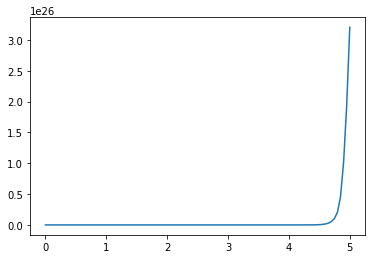

In [23]:
def lognormal_series(t, mu, sigma, spot):
    res = [spot]
    dt = t[1]-t[0]
    for i in t[1:]:
        s = res[-1]
        res.append(mu(i)*s + sigma(t)*s*np.random.standard_normal()/dt)
    return np.array(res)

import matplotlib.pyplot as plt

t = np.linspace(0,5,100)
mu = lambda x: 2
sigma = lambda x: 0.01
res = lognormal_series(t, mu, sigma, 0.001)
plt.plot(t, res)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [35]:
x = np.random.standard_normal(5000)
expectation = lambda aversion: np.mean(x) + np.zeros_like(aversion)
mean_var = lambda aversion: np.mean(x)-aversion/2*np.var(x)
worst_case = lambda aversion: np.min(x)+np.zeros_like(aversion)
entropic = lambda aversion: -np.log(np.mean(np.exp(-aversion[:, None]*x), axis=-1))/aversion


def cvar(aversion):
    w = np.linspace(-10, 10, 1000)
    risk_term = np.mean(np.clip(w[:, None]-x, a_min=0, a_max=np.inf), axis=-1)  # (len(w), )
    risk_term = aversion[:, None]*risk_term     # (len(a), len(w))
    return np.max(-risk_term+w, axis=-1)


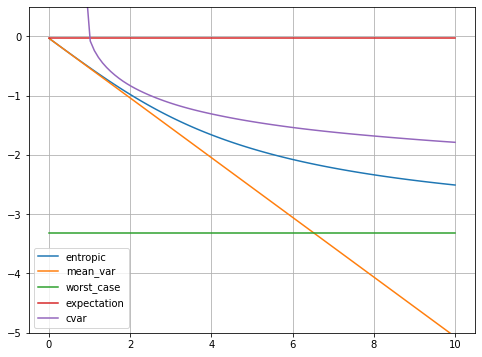

In [37]:
a = np.linspace(0.01,10,100)
plt.figure(figsize=(8,6))
plt.plot(a, entropic(a), label='entropic')
plt.plot(a, mean_var(a), label='mean_var')
plt.plot(a, worst_case(a), label='worst_case')
plt.plot(a, expectation(a), label='expectation')
plt.plot(a, cvar(a), label='cvar')

plt.ylim([-5,0.5])
plt.grid(True)

plt.legend()
plt.show()

In [23]:
worst_case(a)

-3.814779912374024

In [30]:
def optimized_certainty_eq(w, utility, x):
    return w - np.mean(utility(x+w), axis=-1)

def utility(x, a=1.0):
    return (1-np.exp(-a*x))/a

from scipy.optimize import minimize

res = minimize(optimized_certainty_eq, x0=0, args=(utility, np.linspace(0, 10, 100)))

In [31]:
res.fun

-2.2625965078133174